In [1]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

benny_dir = "../benny_faces"
ryan_dir = "../ryan_faces"
other_dir = "../other_faces"

benny_faces = []
ryan_faces = []
other_faces = []

image_height = 256
image_width = 256

for image_name in os.listdir(benny_dir):
    if image_name.lower().endswith(".jpg") or image_name.lower().endswith(".png") or image_name.lower().endswith(".jpeg"):
        img = load_img(os.path.join(benny_dir, image_name), target_size=(image_height, image_width))
        img = img_to_array(img) / 255.0
        benny_faces.append(img)

for image_name in os.listdir(ryan_dir):
    if image_name.lower().endswith(".jpg") or image_name.lower().endswith(".png") or image_name.lower().endswith(".jpeg"):
        img = load_img(os.path.join(ryan_dir, image_name), target_size=(image_height, image_width))
        img = img_to_array(img) / 255.0
        ryan_faces.append(img)

for image_name in os.listdir(other_dir):
    if image_name.lower().endswith(".jpg") or image_name.lower().endswith(".png") or image_name.lower().endswith(".jpeg"):
        img = load_img(os.path.join(other_dir, image_name), target_size=(image_height, image_width))
        img = img_to_array(img) / 255.0
        other_faces.append(img)

benny_faces = np.array(benny_faces)
ryan_faces = np.array(ryan_faces)
other_faces = np.array(other_faces)

In [2]:
print(f"{str(benny_faces.shape[0])} benny faces, {str(ryan_faces.shape[0])} ryan faces, {str(other_faces.shape[0])} other faces")

1540 benny faces, 170 ryan faces, 3510 other faces


In [3]:
from sklearn.model_selection import train_test_split

benny_train, benny_test = train_test_split(benny_faces, test_size=0.15, random_state=42)
ryan_train, ryan_test = train_test_split(ryan_faces, test_size=0.15, random_state=42)
other_train, other_test = train_test_split(other_faces, test_size=0.15, random_state=42)

benny_train, benny_valid = train_test_split(benny_train, test_size=0.15, random_state=42)
ryan_train, ryan_valid = train_test_split(ryan_train, test_size=0.15, random_state=42)
other_train, other_valid = train_test_split(other_train, test_size=0.15, random_state=42)

In [4]:
print(f"benny_train.shape: {benny_train.shape}")
print(f"benny_valid.shape: {benny_valid.shape}")
print(f"benny_test.shape:  {benny_test.shape}")

print(f"ryan_train.shape:  {ryan_train.shape}")
print(f"ryan_valid.shape:  {ryan_valid.shape}")
print(f"ryan_test.shape:   {ryan_test.shape}")

print(f"other_train.shape: {other_train.shape}")
print(f"other_valid.shape: {other_valid.shape}")
print(f"other_test.shape:  {other_test.shape}")

benny_train.shape: (1112, 256, 256, 3)
benny_valid.shape: (197, 256, 256, 3)
benny_test.shape: (231, 256, 256, 3)
ryan_train.shape: (122, 256, 256, 3)
ryan_valid.shape: (22, 256, 256, 3)
ryan_test.shape: (26, 256, 256, 3)
other_train.shape: (2535, 256, 256, 3)
other_valid.shape: (448, 256, 256, 3)
other_test.shape: (527, 256, 256, 3)


In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [6]:
desired_num_of_samples = 2000
aug_benny_train = benny_train
aug_ryan_train = ryan_train

for aug_imgs in datagen.flow(ryan_train, batch_size=ryan_train.shape[0]):
    aug_ryan_train = np.concatenate((aug_ryan_train, aug_imgs))
    if aug_ryan_train.shape[0] >= desired_num_of_samples:
        break

for aug_imgs in datagen.flow(benny_train, batch_size=benny_train.shape[0]):
    aug_benny_train = np.concatenate((aug_benny_train, aug_imgs))
    if aug_benny_train.shape[0] >= desired_num_of_samples:
        break

print(aug_ryan_train.shape)
print(aug_benny_train.shape)

(2074, 256, 256, 3)
(2224, 256, 256, 3)


In [7]:
X_train = np.concatenate((aug_benny_train, aug_ryan_train, other_train))
X_valid = np.concatenate((benny_valid, ryan_valid, other_valid))
X_test = np.concatenate((benny_test, ryan_test, other_test))

y_train = np.array([[1, 0, 0]] * aug_benny_train.shape[0] + [[0, 1, 0]] * aug_ryan_train.shape[0] + [[0, 0, 1]] * other_train.shape[0])
y_valid = np.array([[1, 0, 0]] * benny_valid.shape[0] + [[0, 1, 0]] * ryan_valid.shape[0] + [[0, 0, 1]] * other_valid.shape[0])
y_test = np.array([[1, 0, 0]] * benny_test.shape[0] + [[0, 1, 0]] * ryan_test.shape[0] + [[0, 0, 1]] * other_test.shape[0])

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(6833, 256, 256, 3) (6833, 3)
(667, 256, 256, 3) (667, 3)
(784, 256, 256, 3) (784, 3)


### Model 1

In [13]:
import tensorflow as tf
from tensorflow import keras

model1 = keras.models.Sequential([
    keras.layers.Conv2D(32, 3, (2, 2), activation=None, input_shape=[256, 256, 3], padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(64, 3, (2, 2), activation=None, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(128, 3, (1, 1), activation=None, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(128, 3, (1, 1), activation=None, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(1028, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1028, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [14]:
model1.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
import os

root_logdir = os.path.join(os.curdir, "../my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [16]:
run_log_dir = get_run_logdir()
print(f"Current run log directory: {run_log_dir}")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=run_log_dir)
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

model_dir = "../models/model1"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_dir, save_best_only=True, save_freq="epoch")

history = model1.fit(X_train, y_train, epochs=400, batch_size=32,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_callback, early_stopping, checkpoint_cb, reduce_lr])

Current run log directory: ./../my_logs/run_2024_08_15-10_52_09
Epoch 1/400
214/214 [==============================] - ETA: 0s - loss: 1.7037 - accuracy: 0.4411INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


214/214 [==============================] - 27s 125ms/step - loss: 1.7037 - accuracy: 0.4411 - val_loss: 1.2318 - val_accuracy: 0.1259 - lr: 0.0010
Epoch 2/400
214/214 [==============================] - ETA: 0s - loss: 0.8891 - accuracy: 0.5792INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


214/214 [==============================] - 28s 131ms/step - loss: 0.8891 - accuracy: 0.5792 - val_loss: 0.7374 - val_accuracy: 0.6702 - lr: 0.0010
Epoch 3/400
214/214 [==============================] - ETA: 0s - loss: 0.8357 - accuracy: 0.6150INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


214/214 [==============================] - 29s 137ms/step - loss: 0.8357 - accuracy: 0.6150 - val_loss: 0.6779 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 4/400
214/214 [==============================] - ETA: 0s - loss: 0.7791 - accuracy: 0.6384INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


214/214 [==============================] - 27s 126ms/step - loss: 0.7791 - accuracy: 0.6384 - val_loss: 0.5436 - val_accuracy: 0.7931 - lr: 0.0010
Epoch 5/400
214/214 [==============================] - 26s 123ms/step - loss: 0.7464 - accuracy: 0.6663 - val_loss: 0.6840 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 6/400
214/214 [==============================] - 27s 124ms/step - loss: 0.7050 - accuracy: 0.6909 - val_loss: 0.7024 - val_accuracy: 0.7376 - lr: 0.0010
Epoch 7/400
214/214 [==============================] - 26s 122ms/step - loss: 0.6489 - accuracy: 0.7187 - val_loss: 0.6382 - val_accuracy: 0.7616 - lr: 0.0010
Epoch 8/400
214/214 [==============================] - 25s 117ms/step - loss: 0.6148 - accuracy: 0.7392 - val_loss: 0.5825 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 9/400
214/214 [==============================] - ETA: 0s - loss: 0.5802 - accuracy: 0.7615INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


214/214 [==============================] - 26s 122ms/step - loss: 0.5802 - accuracy: 0.7615 - val_loss: 0.4846 - val_accuracy: 0.8276 - lr: 0.0010
Epoch 10/400
214/214 [==============================] - 26s 120ms/step - loss: 0.5470 - accuracy: 0.7802 - val_loss: 0.6295 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 11/400
214/214 [==============================] - 25s 116ms/step - loss: 0.4956 - accuracy: 0.8080 - val_loss: 0.5999 - val_accuracy: 0.8006 - lr: 0.0010
Epoch 12/400
214/214 [==============================] - ETA: 0s - loss: 0.4652 - accuracy: 0.8174INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


214/214 [==============================] - 25s 118ms/step - loss: 0.4652 - accuracy: 0.8174 - val_loss: 0.4813 - val_accuracy: 0.8621 - lr: 0.0010
Epoch 13/400
214/214 [==============================] - 26s 122ms/step - loss: 0.4361 - accuracy: 0.8292 - val_loss: 0.7361 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 14/400
214/214 [==============================] - 26s 120ms/step - loss: 0.3997 - accuracy: 0.8438 - val_loss: 0.5511 - val_accuracy: 0.7586 - lr: 0.0010
Epoch 15/400
214/214 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8507INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


214/214 [==============================] - 26s 123ms/step - loss: 0.3845 - accuracy: 0.8507 - val_loss: 0.4047 - val_accuracy: 0.8411 - lr: 0.0010
Epoch 16/400
214/214 [==============================] - 27s 126ms/step - loss: 0.3652 - accuracy: 0.8602 - val_loss: 0.4364 - val_accuracy: 0.8366 - lr: 0.0010
Epoch 17/400
214/214 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.8635INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


214/214 [==============================] - 26s 124ms/step - loss: 0.3580 - accuracy: 0.8635 - val_loss: 0.3498 - val_accuracy: 0.8726 - lr: 0.0010
Epoch 18/400
214/214 [==============================] - 26s 122ms/step - loss: 0.3228 - accuracy: 0.8791 - val_loss: 0.4118 - val_accuracy: 0.8276 - lr: 0.0010
Epoch 19/400
214/214 [==============================] - 25s 118ms/step - loss: 0.2970 - accuracy: 0.8856 - val_loss: 0.3965 - val_accuracy: 0.8681 - lr: 0.0010
Epoch 20/400
214/214 [==============================] - 25s 116ms/step - loss: 0.2744 - accuracy: 0.8916 - val_loss: 0.5404 - val_accuracy: 0.7796 - lr: 0.0010
Epoch 21/400
214/214 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.9015INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


214/214 [==============================] - 26s 120ms/step - loss: 0.2506 - accuracy: 0.9015 - val_loss: 0.3419 - val_accuracy: 0.8921 - lr: 0.0010
Epoch 22/400
214/214 [==============================] - 26s 122ms/step - loss: 0.2589 - accuracy: 0.8987 - val_loss: 0.5645 - val_accuracy: 0.8051 - lr: 0.0010
Epoch 23/400
214/214 [==============================] - 25s 119ms/step - loss: 0.2200 - accuracy: 0.9115 - val_loss: 0.3530 - val_accuracy: 0.8876 - lr: 0.0010
Epoch 24/400
214/214 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9151INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


214/214 [==============================] - 26s 120ms/step - loss: 0.2087 - accuracy: 0.9151 - val_loss: 0.3269 - val_accuracy: 0.8876 - lr: 0.0010
Epoch 25/400
214/214 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9229INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


214/214 [==============================] - 30s 139ms/step - loss: 0.1949 - accuracy: 0.9229 - val_loss: 0.3128 - val_accuracy: 0.8786 - lr: 0.0010
Epoch 26/400
214/214 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9267INFO:tensorflow:Assets written to: ../models/model1/assets


INFO:tensorflow:Assets written to: ../models/model1/assets


214/214 [==============================] - 28s 129ms/step - loss: 0.1891 - accuracy: 0.9267 - val_loss: 0.2802 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 27/400
214/214 [==============================] - 27s 127ms/step - loss: 0.1696 - accuracy: 0.9328 - val_loss: 0.3261 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 28/400
214/214 [==============================] - 27s 125ms/step - loss: 0.1680 - accuracy: 0.9339 - val_loss: 0.5303 - val_accuracy: 0.8366 - lr: 0.0010
Epoch 29/400
214/214 [==============================] - 25s 118ms/step - loss: 0.1467 - accuracy: 0.9442 - val_loss: 0.4450 - val_accuracy: 0.8261 - lr: 0.0010
Epoch 30/400
214/214 [==============================] - 25s 116ms/step - loss: 0.1397 - accuracy: 0.9464 - val_loss: 0.3228 - val_accuracy: 0.8891 - lr: 0.0010
Epoch 31/400
214/214 [==============================] - 25s 115ms/step - loss: 0.1426 - accuracy: 0.9423 - val_loss: 0.3842 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 32/400
214/214 [==============================]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [17]:
test_loss, test_acc = model1.evaluate(X_test, y_test, verbose=2)

25/25 - 1s - loss: 0.2521 - accuracy: 0.9260 - 933ms/epoch - 37ms/step


In [18]:
def predict_one(file, model):
    img = load_img(file, target_size=(256, 256))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img_array = np.expand_dims(img_to_array(img), axis=0)
    img_array = img_array / 255.0
    score = model.predict(img_array)
    return score

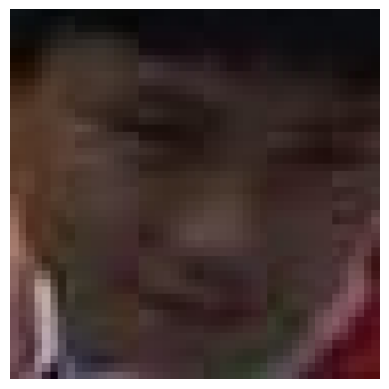

1/1 [==============================] - 0s 101ms/step
[[1.4695732e-02 4.0444339e-04 9.8489976e-01]]


In [19]:
print(predict_one("../other_faces/face1314.jpg", model1))

### Model 2

In [35]:
model2 = keras.models.Sequential([
    keras.layers.Conv2D(64, 3, (2, 2), activation=None, input_shape=[256, 256, 3], padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(64, 3, (2, 2), activation=None, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(128, 3, (1, 1), activation=None, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(256, 3, (1, 1), activation=None, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(1028, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1028, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [36]:
model2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, clipvalue=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
run2_log_dir = get_run_logdir()
print(f"Current run log dir: {run2_log_dir}")
tensorboard_callback2 = keras.callbacks.TensorBoard(log_dir=run2_log_dir)

model2_dir = "../models/model2"
if not os.path.exists(model2_dir):
    os.makedirs(model2_dir)
checkpoint_cb2 = keras.callbacks.ModelCheckpoint(model2_dir, save_best_only=True, save_freq="epoch")

history = model2.fit(X_train, y_train, epochs=400, batch_size=32,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_callback2, early_stopping, checkpoint_cb2])

Current run log dir: ./../my_logs/run_2024_08_15-12_04_52
Epoch 1/400
214/214 [==============================] - ETA: 0s - loss: 1.0492 - accuracy: 0.5623INFO:tensorflow:Assets written to: ../models/model2/assets


INFO:tensorflow:Assets written to: ../models/model2/assets


214/214 [==============================] - 47s 216ms/step - loss: 1.0492 - accuracy: 0.5623 - val_loss: 1.4919 - val_accuracy: 0.0345
Epoch 2/400
214/214 [==============================] - ETA: 0s - loss: 0.7210 - accuracy: 0.6861INFO:tensorflow:Assets written to: ../models/model2/assets


INFO:tensorflow:Assets written to: ../models/model2/assets


214/214 [==============================] - 48s 226ms/step - loss: 0.7210 - accuracy: 0.6861 - val_loss: 1.1427 - val_accuracy: 0.3838
Epoch 3/400
214/214 [==============================] - ETA: 0s - loss: 0.6347 - accuracy: 0.7253INFO:tensorflow:Assets written to: ../models/model2/assets


INFO:tensorflow:Assets written to: ../models/model2/assets


214/214 [==============================] - 49s 229ms/step - loss: 0.6347 - accuracy: 0.7253 - val_loss: 0.5306 - val_accuracy: 0.7946
Epoch 4/400
214/214 [==============================] - ETA: 0s - loss: 0.5483 - accuracy: 0.7688INFO:tensorflow:Assets written to: ../models/model2/assets


INFO:tensorflow:Assets written to: ../models/model2/assets


214/214 [==============================] - 48s 224ms/step - loss: 0.5483 - accuracy: 0.7688 - val_loss: 0.5209 - val_accuracy: 0.8126
Epoch 5/400
214/214 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.8037INFO:tensorflow:Assets written to: ../models/model2/assets


INFO:tensorflow:Assets written to: ../models/model2/assets


214/214 [==============================] - 47s 220ms/step - loss: 0.4805 - accuracy: 0.8037 - val_loss: 0.4526 - val_accuracy: 0.8366
Epoch 6/400
214/214 [==============================] - 47s 221ms/step - loss: 0.4375 - accuracy: 0.8181 - val_loss: 0.4603 - val_accuracy: 0.8291
Epoch 7/400
214/214 [==============================] - 44s 206ms/step - loss: 0.3692 - accuracy: 0.8519 - val_loss: 0.5437 - val_accuracy: 0.8276
Epoch 8/400
214/214 [==============================] - 45s 210ms/step - loss: 0.3454 - accuracy: 0.8626 - val_loss: 0.4888 - val_accuracy: 0.8381
Epoch 9/400
214/214 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.8835INFO:tensorflow:Assets written to: ../models/model2/assets


INFO:tensorflow:Assets written to: ../models/model2/assets


214/214 [==============================] - 48s 224ms/step - loss: 0.3003 - accuracy: 0.8835 - val_loss: 0.3721 - val_accuracy: 0.8981
Epoch 10/400
214/214 [==============================] - 48s 226ms/step - loss: 0.2702 - accuracy: 0.8951 - val_loss: 0.4480 - val_accuracy: 0.8621
Epoch 11/400
214/214 [==============================] - 44s 203ms/step - loss: 0.2399 - accuracy: 0.9093 - val_loss: 0.4502 - val_accuracy: 0.8846
Epoch 12/400
214/214 [==============================] - 44s 206ms/step - loss: 0.2062 - accuracy: 0.9197 - val_loss: 0.4790 - val_accuracy: 0.8756
Epoch 13/400
214/214 [==============================] - 44s 207ms/step - loss: 0.1837 - accuracy: 0.9315 - val_loss: 0.7259 - val_accuracy: 0.8141
Epoch 14/400
214/214 [==============================] - 45s 209ms/step - loss: 0.1824 - accuracy: 0.9339 - val_loss: 0.4172 - val_accuracy: 0.8936
Epoch 15/400
214/214 [==============================] - 46s 214ms/step - loss: 0.1526 - accuracy: 0.9419 - val_loss: 0.4241 - val_a

In [38]:
test_loss2, test_acc2 = model2.evaluate(X_test, y_test, verbose=2)

25/25 - 2s - loss: 0.2806 - accuracy: 0.9031 - 2s/epoch - 62ms/step


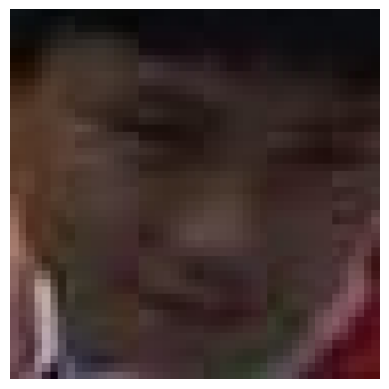

1/1 [==============================] - 0s 65ms/step
[[0.01180485 0.03620426 0.9519909 ]]


In [39]:
print(predict_one("../other_faces/face1314.jpg", model2))

### Model 3

In [28]:
model3 = keras.models.Sequential([
    keras.layers.Conv2D(64, 3, (2, 2), activation=None, input_shape=[256, 256, 3], padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(64, 3, (2, 2), activation=None, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(128, 3, (1, 1), activation=None, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(256, 3, (1, 1), activation=None, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(1028, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1028, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [29]:
model3.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, clipvalue=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
run3_log_dir = get_run_logdir()
print(f"Current run log dir: {run3_log_dir}")
tensorboard_callback3 = keras.callbacks.TensorBoard(log_dir=run3_log_dir)

model3_dir = "../models/model3"
if not os.path.exists(model3_dir):
    os.makedirs(model3_dir)
checkpoint_cb3 = keras.callbacks.ModelCheckpoint(model3_dir, save_best_only=True, save_freq="epoch")

history = model3.fit(X_train, y_train, epochs=400, batch_size=32,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_callback3, early_stopping, checkpoint_cb3, reduce_lr])

Current run log dir: ./../my_logs/run_2024_08_15-11_45_13
Epoch 1/400
214/214 [==============================] - ETA: 0s - loss: 1.0217 - accuracy: 0.5686INFO:tensorflow:Assets written to: ../models/model3/assets


INFO:tensorflow:Assets written to: ../models/model3/assets


214/214 [==============================] - 47s 216ms/step - loss: 1.0217 - accuracy: 0.5686 - val_loss: 1.1130 - val_accuracy: 0.3913 - lr: 1.0000e-04
Epoch 2/400
214/214 [==============================] - ETA: 0s - loss: 0.7300 - accuracy: 0.6834INFO:tensorflow:Assets written to: ../models/model3/assets


INFO:tensorflow:Assets written to: ../models/model3/assets


214/214 [==============================] - 48s 223ms/step - loss: 0.7300 - accuracy: 0.6834 - val_loss: 1.0102 - val_accuracy: 0.4483 - lr: 1.0000e-04
Epoch 3/400
214/214 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.7408INFO:tensorflow:Assets written to: ../models/model3/assets


INFO:tensorflow:Assets written to: ../models/model3/assets


214/214 [==============================] - 48s 224ms/step - loss: 0.6192 - accuracy: 0.7408 - val_loss: 0.5382 - val_accuracy: 0.7916 - lr: 1.0000e-04
Epoch 4/400
214/214 [==============================] - ETA: 0s - loss: 0.5321 - accuracy: 0.7746INFO:tensorflow:Assets written to: ../models/model3/assets


INFO:tensorflow:Assets written to: ../models/model3/assets


214/214 [==============================] - 47s 221ms/step - loss: 0.5321 - accuracy: 0.7746 - val_loss: 0.4365 - val_accuracy: 0.8426 - lr: 1.0000e-04
Epoch 5/400
214/214 [==============================] - 47s 219ms/step - loss: 0.4704 - accuracy: 0.8093 - val_loss: 0.4460 - val_accuracy: 0.8261 - lr: 1.0000e-04
Epoch 6/400
214/214 [==============================] - 44s 207ms/step - loss: 0.4114 - accuracy: 0.8343 - val_loss: 0.5087 - val_accuracy: 0.8231 - lr: 1.0000e-04
Epoch 7/400
214/214 [==============================] - ETA: 0s - loss: 0.3707 - accuracy: 0.8523INFO:tensorflow:Assets written to: ../models/model3/assets


INFO:tensorflow:Assets written to: ../models/model3/assets


214/214 [==============================] - 46s 213ms/step - loss: 0.3707 - accuracy: 0.8523 - val_loss: 0.3816 - val_accuracy: 0.8801 - lr: 1.0000e-04
Epoch 8/400
214/214 [==============================] - 49s 229ms/step - loss: 0.3218 - accuracy: 0.8752 - val_loss: 0.4389 - val_accuracy: 0.8516 - lr: 1.0000e-04
Epoch 9/400
214/214 [==============================] - 47s 218ms/step - loss: 0.2870 - accuracy: 0.8885 - val_loss: 0.5806 - val_accuracy: 0.8216 - lr: 1.0000e-04
Epoch 10/400
214/214 [==============================] - 43s 202ms/step - loss: 0.2642 - accuracy: 0.8946 - val_loss: 0.3963 - val_accuracy: 0.8891 - lr: 1.0000e-04
Epoch 11/400
214/214 [==============================] - 44s 205ms/step - loss: 0.2314 - accuracy: 0.9132 - val_loss: 0.3907 - val_accuracy: 0.8951 - lr: 1.0000e-04
Epoch 12/400
214/214 [==============================] - 44s 207ms/step - loss: 0.2072 - accuracy: 0.9230 - val_loss: 0.4097 - val_accuracy: 0.8801 - lr: 1.0000e-04
Epoch 13/400
214/214 [=========

INFO:tensorflow:Assets written to: ../models/model3/assets


214/214 [==============================] - 44s 208ms/step - loss: 0.1345 - accuracy: 0.9513 - val_loss: 0.3716 - val_accuracy: 0.8996 - lr: 5.0000e-05
Epoch 14/400
214/214 [==============================] - 49s 227ms/step - loss: 0.1134 - accuracy: 0.9595 - val_loss: 0.4219 - val_accuracy: 0.8891 - lr: 5.0000e-05
Epoch 15/400
214/214 [==============================] - 45s 209ms/step - loss: 0.0966 - accuracy: 0.9663 - val_loss: 0.4229 - val_accuracy: 0.9070 - lr: 5.0000e-05
Epoch 16/400
214/214 [==============================] - 45s 209ms/step - loss: 0.0846 - accuracy: 0.9706 - val_loss: 0.4177 - val_accuracy: 0.9130 - lr: 5.0000e-05
Epoch 17/400
214/214 [==============================] - 45s 212ms/step - loss: 0.0749 - accuracy: 0.9753 - val_loss: 0.4333 - val_accuracy: 0.9055 - lr: 5.0000e-05
Epoch 18/400
214/214 [==============================] - 46s 217ms/step - loss: 0.0672 - accuracy: 0.9785 - val_loss: 0.4447 - val_accuracy: 0.9040 - lr: 5.0000e-05
Epoch 19/400
214/214 [=======

In [31]:
test_loss3, test_acc3 = model3.evaluate(X_test, y_test, verbose=2)

25/25 - 1s - loss: 0.2556 - accuracy: 0.9184 - 1s/epoch - 54ms/step


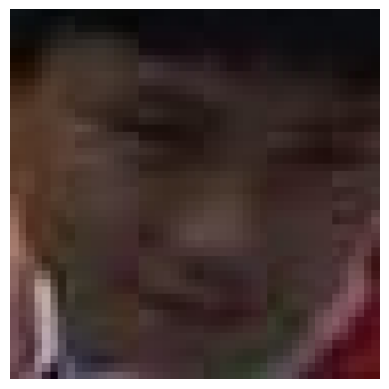

1/1 [==============================] - 0s 75ms/step
[[1.3978127e-03 4.7455341e-04 9.9812764e-01]]


In [40]:
print(predict_one("../other_faces/face1314.jpg", model3))